<a href="https://colab.research.google.com/github/YasinnSoylu/actt/blob/main/act.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
! mkdir ~/.kaggle


mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
! cp kaggle.json ~/.kaggle/


In [ ]:
! chmod 600 ~/.kaggle/kaggle.json


In [ ]:
!kaggle datasets download -d kmader/skin-cancer-mnist-ham10000

skin-cancer-mnist-ham10000.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
! unzip skin-cancer-mnist-ham10000.zip


Görüntülenen çıkış son 5000 satıra kısaltıldı.
  inflating: ham10000_images_part_2/ISIC_0029325.jpg  
  inflating: ham10000_images_part_2/ISIC_0029326.jpg  
  inflating: ham10000_images_part_2/ISIC_0029327.jpg  
  inflating: ham10000_images_part_2/ISIC_0029328.jpg  
  inflating: ham10000_images_part_2/ISIC_0029329.jpg  
  inflating: ham10000_images_part_2/ISIC_0029330.jpg  
  inflating: ham10000_images_part_2/ISIC_0029331.jpg  
  inflating: ham10000_images_part_2/ISIC_0029332.jpg  
  inflating: ham10000_images_part_2/ISIC_0029333.jpg  
  inflating: ham10000_images_part_2/ISIC_0029334.jpg  
  inflating: ham10000_images_part_2/ISIC_0029335.jpg  
  inflating: ham10000_images_part_2/ISIC_0029336.jpg  
  inflating: ham10000_images_part_2/ISIC_0029337.jpg  
  inflating: ham10000_images_part_2/ISIC_0029338.jpg  
  inflating: ham10000_images_part_2/ISIC_0029339.jpg  
  inflating: ham10000_images_part_2/ISIC_0029340.jpg  
  inflating: ham10000_images_part_2/ISIC_0029341.jpg  
  inflating: ham10

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
from PIL import Image
np.random.seed(123)
from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix
import itertools

import keras
from keras.utils.np_utils import to_categorical # used for converting labels to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras import backend as K
import itertools
from tensorflow.keras.layers import BatchNormalization
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from tensorflow.keras.callbacks import ModelCheckpoint

from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import train_test_split

In [ ]:
image_path = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join('/content/HAM10000/', '*', '*.jpg'))}

lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}                     

In [ ]:
skin_df = pd.read_csv(os.path.join( '/content/HAM10000/HAM10000_metadata.csv'))


In [ ]:
skin_df['path'] = skin_df['image_id'].map(image_path.get)
skin_df['cell_type'] = skin_df['dx'].map(lesion_type_dict.get) 
skin_df['cell_type_idx'] = pd.Categorical(skin_df['cell_type']).codes

In [ ]:
skin_df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,/content/HAM10000/ham10000_images_part_1/ISIC_...,Benign keratosis-like lesions,2
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,/content/HAM10000/ham10000_images_part_1/ISIC_...,Benign keratosis-like lesions,2
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,/content/HAM10000/ham10000_images_part_1/ISIC_...,Benign keratosis-like lesions,2
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,/content/HAM10000/ham10000_images_part_1/ISIC_...,Benign keratosis-like lesions,2
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,/content/HAM10000/ham10000_images_part_2/ISIC_...,Benign keratosis-like lesions,2


In [ ]:
skin_df['path'] = skin_df['image_id'].map(image_path.get)
#Use the path to read images.
skin_df['image'] = skin_df['path'].map(lambda x: np.asarray(Image.open(x).resize((32,32))))

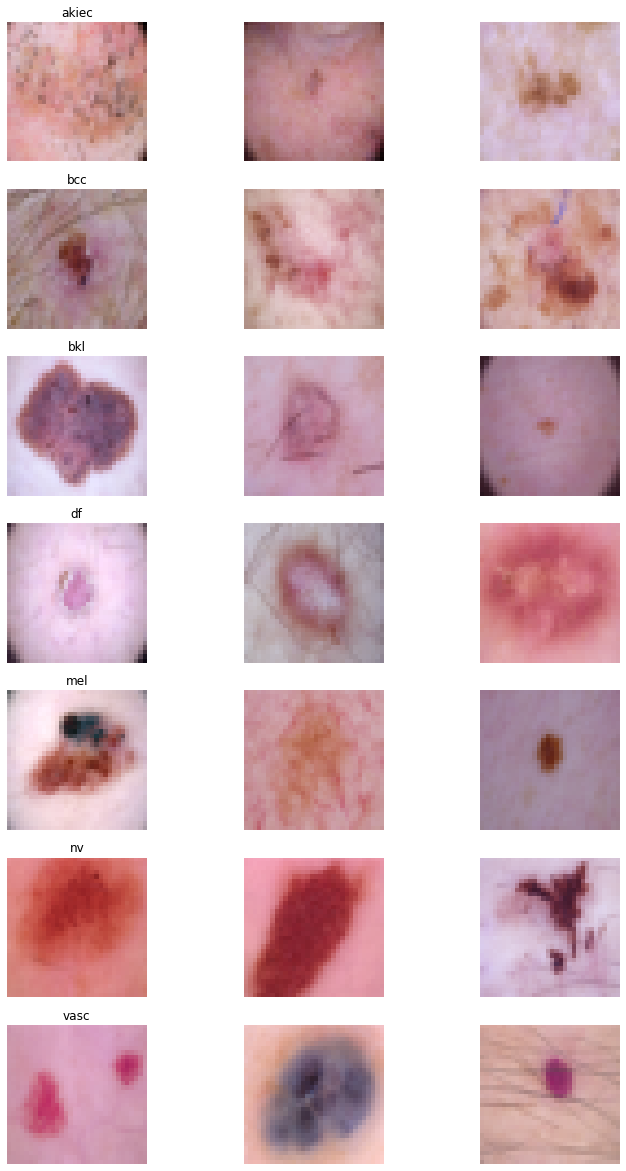

In [ ]:
n_samples = 3  # number of samples for plotting
# Plotting
fig, m_axs = plt.subplots(7, n_samples, figsize = (4*n_samples, 3*7))
for n_axs, (type_name, type_rows) in zip(m_axs, 
                                         skin_df.sort_values(['dx']).groupby('dx')):
    n_axs[0].set_title(type_name)
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state=42).iterrows()):
        c_ax.imshow(c_row['image'])
        c_ax.axis('off')
fig.savefig('category_samples.png', dpi=300)


In [ ]:
skin_df['image'].map(lambda x: x.shape).value_counts()

(32, 32, 3)    10015
Name: image, dtype: int64

In [ ]:
skin_df.isnull().sum()

lesion_id         0
image_id          0
dx                0
dx_type           0
age              57
sex               0
localization      0
path              0
cell_type         0
cell_type_idx     0
image             0
dtype: int64

In [ ]:
skin_df['age'].fillna((skin_df['age'].mean()), inplace=True)

In [ ]:
skin_df

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx,image
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,/content/HAM10000/ham10000_images_part_1/ISIC_...,Benign keratosis-like lesions,2,"[[[191, 152, 192], [194, 154, 193], [196, 152,..."
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,/content/HAM10000/ham10000_images_part_1/ISIC_...,Benign keratosis-like lesions,2,"[[[24, 14, 29], [56, 39, 64], [106, 80, 112], ..."
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,/content/HAM10000/ham10000_images_part_1/ISIC_...,Benign keratosis-like lesions,2,"[[[190, 136, 150], [199, 145, 161], [200, 141,..."
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,/content/HAM10000/ham10000_images_part_1/ISIC_...,Benign keratosis-like lesions,2,"[[[35, 18, 28], [83, 51, 64], [128, 88, 103], ..."
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,/content/HAM10000/ham10000_images_part_2/ISIC_...,Benign keratosis-like lesions,2,"[[[155, 110, 135], [188, 139, 168], [210, 157,..."
...,...,...,...,...,...,...,...,...,...,...,...
10010,HAM_0002867,ISIC_0033084,akiec,histo,40.0,male,abdomen,/content/HAM10000/ham10000_images_part_2/ISIC_...,Actinic keratoses,0,"[[[181, 164, 179], [179, 162, 176], [180, 163,..."
10011,HAM_0002867,ISIC_0033550,akiec,histo,40.0,male,abdomen,/content/HAM10000/ham10000_images_part_2/ISIC_...,Actinic keratoses,0,"[[[4, 5, 3], [24, 22, 21], [101, 88, 88], [128..."
10012,HAM_0002867,ISIC_0033536,akiec,histo,40.0,male,abdomen,/content/HAM10000/ham10000_images_part_2/ISIC_...,Actinic keratoses,0,"[[[132, 119, 120], [157, 139, 138], [177, 158,..."
10013,HAM_0000239,ISIC_0032854,akiec,histo,80.0,male,face,/content/HAM10000/ham10000_images_part_2/ISIC_...,Actinic keratoses,0,"[[[160, 123, 144], [163, 131, 152], [166, 128,..."


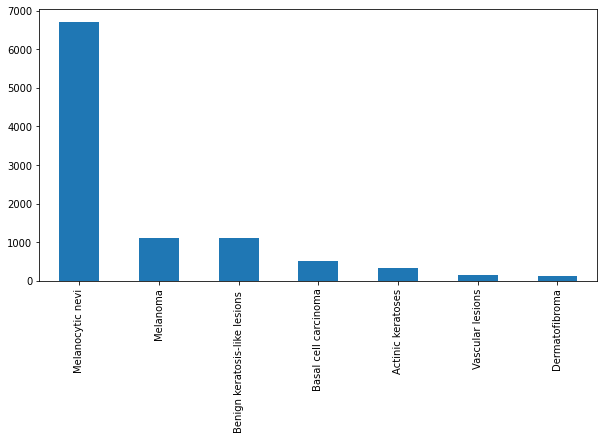

In [ ]:
fig, ax1 = plt.subplots(1, 1, figsize= (10, 5))
skin_df['cell_type'].value_counts().plot(kind='bar', ax=ax1)

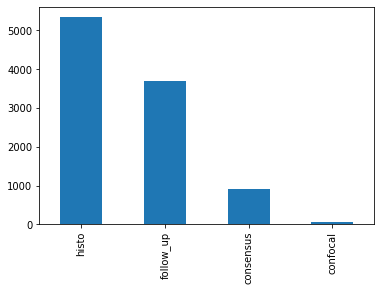

In [ ]:
skin_df['dx_type'].value_counts().plot(kind='bar')

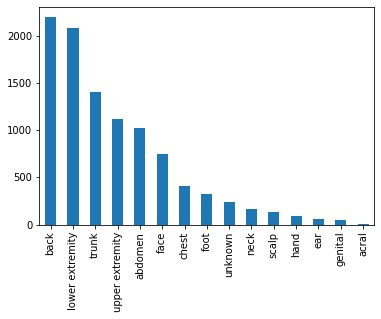

In [ ]:
skin_df['localization'].value_counts().plot(kind='bar')

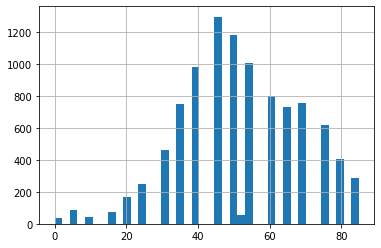

In [ ]:
skin_df['age'].hist(bins=40)

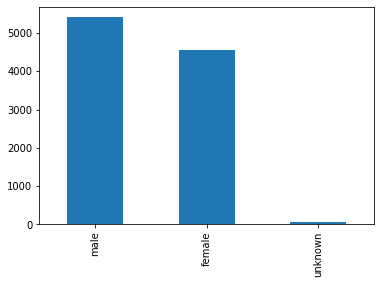

In [ ]:
skin_df['sex'].value_counts().plot(kind='bar')

In [ ]:
features=skin_df.drop(columns=['cell_type_idx'],axis=1)
target=skin_df['cell_type_idx']

In [ ]:
x_train_o, x_test_o, y_train_o, y_test_o = train_test_split(features, target, test_size=0.20,random_state=42)

x_train = np.asarray(x_train_o['image'].tolist())
x_test = np.asarray(x_test_o['image'].tolist())

x_train_mean = np.mean(x_train)
x_train_std = np.std(x_train)

x_test_mean = np.mean(x_test)
x_test_std = np.std(x_test)

x_train = (x_train - x_train_mean)/x_train_std
x_test = (x_test - x_test_mean)/x_test_std

In [ ]:
# Perform one-hot encoding on the labels
y_train = to_categorical(y_train_o, num_classes = 7)
y_test = to_categorical(y_test_o, num_classes = 7)

In [ ]:
x_train, x_validate, y_train, y_validate = train_test_split(x_train, y_train, test_size = 0.1, random_state = 2)

In [ ]:
# Reshape image in 3 dimensions (height = 128px, width = 128px , canal = 3)
x_train = x_train.reshape(x_train.shape[0], *(32, 32, 3))
x_test = x_test.reshape(x_test.shape[0], *(32, 32, 3))
x_validate = x_validate.reshape(x_validate.shape[0], *(32, 32, 3))

In [ ]:
# With data augmentation to prevent overfitting 

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images

datagen.fit(x_train)

# Fitting the model using LeakyReLU

In [ ]:
from tensorflow.keras.layers import LeakyReLU, Dense
act = LeakyReLU()

In [ ]:

input_shape = (32, 32, 3)
num_classes = 7

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),activation=act,padding = 'Same',input_shape=input_shape))
model.add(Conv2D(32,kernel_size=(3, 3), activation=act,padding = 'Same',))
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation=act,padding = 'Same'))
model.add(Conv2D(64, (3, 3), activation=act,padding = 'Same'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.40))

model.add(Flatten())
model.add(Dense(128, activation=act))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 16, 16, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 16, 16, 64)        36928     
                                                        

In [ ]:
# Define the optimizer
optimizer = Adam(lr=0.001)
# Compile the model
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
reduce_lr = ReduceLROnPlateau(monitor='val_acc', factor=0.2,
                              patience=5,mode="max")


filepath="best_model_LeakyReLU.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

In [ ]:
# Fit the model
epochs = 10 
batch_size = 64
history_LeakyReLU= model.fit_generator(datagen.flow(x_train,y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (x_validate,y_validate),
                              verbose = 1, steps_per_epoch=x_train.shape[0] // batch_size
                              , callbacks=[reduce_lr,checkpoint])

<ipython-input-39-ff4ebfdf264d>:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history_LeakyReLU= model.fit_generator(datagen.flow(x_train,y_train, batch_size=batch_size),


Epoch 1/10
112/112 [==============================] - ETA: 0s - loss: 0.9943 - accuracy: 0.6696

112/112 [==============================] - 42s 366ms/step - loss: 0.9943 - accuracy: 0.6696 - val_loss: 0.9756 - val_accuracy: 0.6284 - lr: 0.0010
Epoch 2/10
112/112 [==============================] - ETA: 0s - loss: 0.8472 - accuracy: 0.6951

112/112 [==============================] - 42s 375ms/step - loss: 0.8472 - accuracy: 0.6951 - val_loss: 0.8709 - val_accuracy: 0.6796 - lr: 0.0010
Epoch 3/10
112/112 [==============================] - ETA: 0s - loss: 0.7895 - accuracy: 0.7180

112/112 [==============================] - 41s 364ms/step - loss: 0.7895 - accuracy: 0.7180 - val_loss: 0.8329 - val_accuracy: 0.6833 - lr: 0.0010
Epoch 4/10
112/112 [==============================] - ETA: 0s - loss: 0.7516 - accuracy: 0.7347

112/112 [==============================] - 41s 363ms/step - loss: 0.7516 - accuracy: 0.7347 - val_loss: 0.8073 - val_accuracy: 0.6995 - lr: 0.0010
Epoch 5/10
112/112 [==============================] - ETA: 0s - loss: 0.7216 - accuracy: 0.7373

112/112 [==============================] - 41s 362ms/step - loss: 0.7216 - accuracy: 0.7373 - val_loss: 0.8433 - val_accuracy: 0.6858 - lr: 0.0010
Epoch 6/10
112/112 [==============================] - ETA: 0s - loss: 0.7073 - accuracy: 0.7480

112/112 [==============================] - 41s 363ms/step - loss: 0.7073 - accuracy: 0.7480 - val_loss: 0.8200 - val_accuracy: 0.6633 - lr: 0.0010
Epoch 7/10
112/112 [==============================] - ETA: 0s - loss: 0.7007 - accuracy: 0.7445

112/112 [==============================] - 42s 376ms/step - loss: 0.7007 - accuracy: 0.7445 - val_loss: 0.7850 - val_accuracy: 0.7120 - lr: 0.0010
Epoch 8/10
112/112 [==============================] - ETA: 0s - loss: 0.6805 - accuracy: 0.7484

112/112 [==============================] - 41s 363ms/step - loss: 0.6805 - accuracy: 0.7484 - val_loss: 0.7760 - val_accuracy: 0.6958 - lr: 0.0010
Epoch 9/10
112/112 [==============================] - ETA: 0s - loss: 0.6765 - accuracy: 0.7555

112/112 [==============================] - 41s 363ms/step - loss: 0.6765 - accuracy: 0.7555 - val_loss: 0.7720 - val_accuracy: 0.6883 - lr: 0.0010
Epoch 10/10
112/112 [==============================] - ETA: 0s - loss: 0.6581 - accuracy: 0.7579

112/112 [==============================] - 41s 364ms/step - loss: 0.6581 - accuracy: 0.7579 - val_loss: 0.7211 - val_accuracy: 0.7219 - lr: 0.0010


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


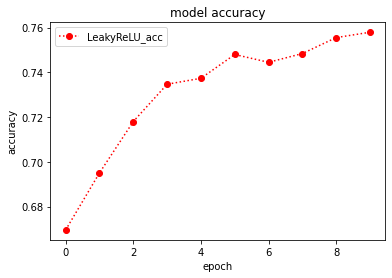

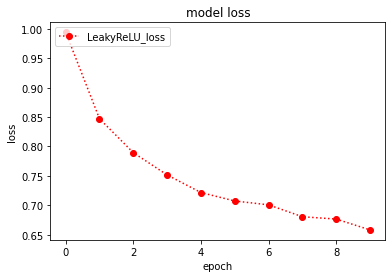

In [ ]:
print(history_LeakyReLU.history.keys())
# summarize history for accuracy
plt.plot(history_LeakyReLU.history['accuracy'] ,'o:r')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['LeakyReLU_acc'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history_LeakyReLU.history['loss'],'o:r')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['LeakyReLU_loss', ], loc='upper left')
plt.show()

# relu

In [ ]:
# Set the CNN model 
# my CNN architechture is In -> [[Conv2D->relu]*2 -> MaxPool2D -> Dropout]*2 -> Flatten -> Dense -> Dropout -> Out
input_shape = (32, 32, 3)
num_classes = 7

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),activation='relu',padding = 'Same',input_shape=input_shape))
model.add(Conv2D(32,kernel_size=(3, 3), activation='relu',padding = 'Same',))
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu',padding = 'Same'))
model.add(Conv2D(64, (3, 3), activation='relu',padding = 'Same'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.40))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 32, 32, 32)        896       
                                                                 
 conv2d_5 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 dropout_3 (Dropout)         (None, 16, 16, 32)        0         
                                                                 
 conv2d_6 (Conv2D)           (None, 16, 16, 64)        18496     
                                                                 
 conv2d_7 (Conv2D)           (None, 16, 16, 64)        36928     
                                                      

In [ ]:
# Define the optimizer
optimizer = Adam(lr=0.001)
# Compile the model
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

In [ ]:
# Fit the model
epochs = 10 
batch_size = 128
history_relu= model.fit_generator(datagen.flow(x_train,y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (x_validate,y_validate),
                              verbose = 1, steps_per_epoch=x_train.shape[0] // batch_size
                              , callbacks=[reduce_lr,checkpoint])

Epoch 1/10


<ipython-input-48-cc3dd2a50167>:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history_relu= model.fit_generator(datagen.flow(x_train,y_train, batch_size=batch_size),


56/56 [==============================] - ETA: 0s - loss: 1.0400 - accuracy: 0.6604

56/56 [==============================] - 39s 679ms/step - loss: 1.0400 - accuracy: 0.6604 - val_loss: 1.0493 - val_accuracy: 0.6359 - lr: 0.0010
Epoch 2/10
56/56 [==============================] - ETA: 0s - loss: 0.9120 - accuracy: 0.6703

56/56 [==============================] - 38s 683ms/step - loss: 0.9120 - accuracy: 0.6703 - val_loss: 0.9170 - val_accuracy: 0.6584 - lr: 0.0010
Epoch 3/10
56/56 [==============================] - ETA: 0s - loss: 0.8793 - accuracy: 0.6796

56/56 [==============================] - 38s 673ms/step - loss: 0.8793 - accuracy: 0.6796 - val_loss: 0.9284 - val_accuracy: 0.6608 - lr: 0.0010
Epoch 4/10
56/56 [==============================] - ETA: 0s - loss: 0.8309 - accuracy: 0.6943

56/56 [==============================] - 39s 701ms/step - loss: 0.8309 - accuracy: 0.6943 - val_loss: 0.8962 - val_accuracy: 0.6808 - lr: 0.0010
Epoch 5/10
56/56 [==============================] - ETA: 0s - loss: 0.8109 - accuracy: 0.7073

56/56 [==============================] - 38s 672ms/step - loss: 0.8109 - accuracy: 0.7073 - val_loss: 0.8451 - val_accuracy: 0.6820 - lr: 0.0010
Epoch 6/10
56/56 [==============================] - ETA: 0s - loss: 0.7832 - accuracy: 0.7158

56/56 [==============================] - 38s 675ms/step - loss: 0.7832 - accuracy: 0.7158 - val_loss: 0.8270 - val_accuracy: 0.7007 - lr: 0.0010
Epoch 7/10
56/56 [==============================] - ETA: 0s - loss: 0.7657 - accuracy: 0.7190

56/56 [==============================] - 38s 677ms/step - loss: 0.7657 - accuracy: 0.7190 - val_loss: 0.8144 - val_accuracy: 0.7020 - lr: 0.0010
Epoch 8/10
56/56 [==============================] - ETA: 0s - loss: 0.7554 - accuracy: 0.7252

56/56 [==============================] - 38s 673ms/step - loss: 0.7554 - accuracy: 0.7252 - val_loss: 0.7927 - val_accuracy: 0.6995 - lr: 0.0010
Epoch 9/10
56/56 [==============================] - ETA: 0s - loss: 0.7287 - accuracy: 0.7285

56/56 [==============================] - 39s 695ms/step - loss: 0.7287 - accuracy: 0.7285 - val_loss: 0.7734 - val_accuracy: 0.6920 - lr: 0.0010
Epoch 10/10
56/56 [==============================] - ETA: 0s - loss: 0.7238 - accuracy: 0.7408

56/56 [==============================] - 48s 868ms/step - loss: 0.7238 - accuracy: 0.7408 - val_loss: 0.7955 - val_accuracy: 0.6883 - lr: 0.0010


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


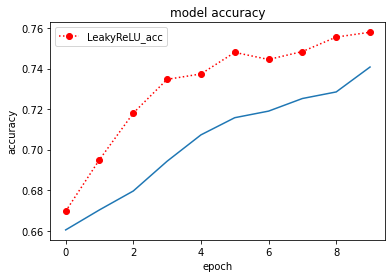

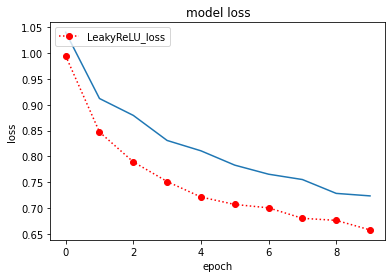

In [ ]:
print(history_LeakyReLU.history.keys())
# summarize history for accuracy
plt.plot(history_LeakyReLU.history['accuracy'] ,'o:r')
plt.plot(history_relu.history['accuracy'] )




plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['LeakyReLU_acc'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history_LeakyReLU.history['loss'],'o:r')
plt.plot(history_relu.history['loss'])





plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['LeakyReLU_loss', ], loc='upper left')
plt.show()

# sigmoid

In [ ]:
# Set the CNN model 
# my CNN architechture is In -> [[Conv2D->relu]*2 -> MaxPool2D -> Dropout]*2 -> Flatten -> Dense -> Dropout -> Out
input_shape = (32, 32, 3)
num_classes = 7

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),activation='sigmoid',padding = 'Same',input_shape=input_shape))
model.add(Conv2D(32,kernel_size=(3, 3), activation='sigmoid',padding = 'Same',))
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='sigmoid',padding = 'Same'))
model.add(Conv2D(64, (3, 3), activation='sigmoid',padding = 'Same'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.40))

model.add(Flatten())
model.add(Dense(128, activation='sigmoid'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))
model.summary()


# Define the optimizer
optimizer = Adam(lr=0.001)
# Compile the model
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])


# Fit the model
epochs = 10 
batch_size = 128
history_sigmoid= model.fit_generator(datagen.flow(x_train,y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (x_validate,y_validate),
                              verbose = 1, steps_per_epoch=x_train.shape[0] // batch_size
                              , callbacks=[reduce_lr,checkpoint])

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 32, 32, 32)        896       
                                                                 
 conv2d_9 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 dropout_6 (Dropout)         (None, 16, 16, 32)        0         
                                                                 
 conv2d_10 (Conv2D)          (None, 16, 16, 64)        18496     
                                                                 
 conv2d_11 (Conv2D)          (None, 16, 16, 64)        36928     
                                                      

<ipython-input-52-526a84d83fc8>:33: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history_sigmoid= model.fit_generator(datagen.flow(x_train,y_train, batch_size=batch_size),


Epoch 1/10
56/56 [==============================] - ETA: 0s - loss: 1.3382 - accuracy: 0.6326

56/56 [==============================] - 42s 725ms/step - loss: 1.3382 - accuracy: 0.6326 - val_loss: 1.1923 - val_accuracy: 0.6434 - lr: 0.0010
Epoch 2/10
56/56 [==============================] - ETA: 0s - loss: 1.1911 - accuracy: 0.6692

56/56 [==============================] - 39s 687ms/step - loss: 1.1911 - accuracy: 0.6692 - val_loss: 1.1815 - val_accuracy: 0.6434 - lr: 0.0010
Epoch 3/10
56/56 [==============================] - ETA: 0s - loss: 1.1141 - accuracy: 0.6734

56/56 [==============================] - 40s 722ms/step - loss: 1.1141 - accuracy: 0.6734 - val_loss: 1.0952 - val_accuracy: 0.6434 - lr: 0.0010
Epoch 4/10
56/56 [==============================] - ETA: 0s - loss: 1.0401 - accuracy: 0.6740

56/56 [==============================] - 38s 685ms/step - loss: 1.0401 - accuracy: 0.6740 - val_loss: 1.0712 - val_accuracy: 0.6434 - lr: 0.0010
Epoch 5/10
56/56 [==============================] - ETA: 0s - loss: 1.0291 - accuracy: 0.6733

56/56 [==============================] - 38s 685ms/step - loss: 1.0291 - accuracy: 0.6733 - val_loss: 1.0559 - val_accuracy: 0.6434 - lr: 0.0010
Epoch 6/10
56/56 [==============================] - ETA: 0s - loss: 1.0186 - accuracy: 0.6730

56/56 [==============================] - 40s 707ms/step - loss: 1.0186 - accuracy: 0.6730 - val_loss: 1.0527 - val_accuracy: 0.6434 - lr: 0.0010
Epoch 7/10
56/56 [==============================] - ETA: 0s - loss: 1.0098 - accuracy: 0.6717

56/56 [==============================] - 38s 684ms/step - loss: 1.0098 - accuracy: 0.6717 - val_loss: 1.0459 - val_accuracy: 0.6434 - lr: 0.0010
Epoch 8/10
56/56 [==============================] - ETA: 0s - loss: 1.0023 - accuracy: 0.6724

56/56 [==============================] - 38s 685ms/step - loss: 1.0023 - accuracy: 0.6724 - val_loss: 1.0457 - val_accuracy: 0.6434 - lr: 0.0010
Epoch 9/10
56/56 [==============================] - ETA: 0s - loss: 0.9904 - accuracy: 0.6735

56/56 [==============================] - 38s 684ms/step - loss: 0.9904 - accuracy: 0.6735 - val_loss: 1.0145 - val_accuracy: 0.6434 - lr: 0.0010
Epoch 10/10
56/56 [==============================] - ETA: 0s - loss: 0.9842 - accuracy: 0.6726

56/56 [==============================] - 40s 711ms/step - loss: 0.9842 - accuracy: 0.6726 - val_loss: 1.0195 - val_accuracy: 0.6434 - lr: 0.0010


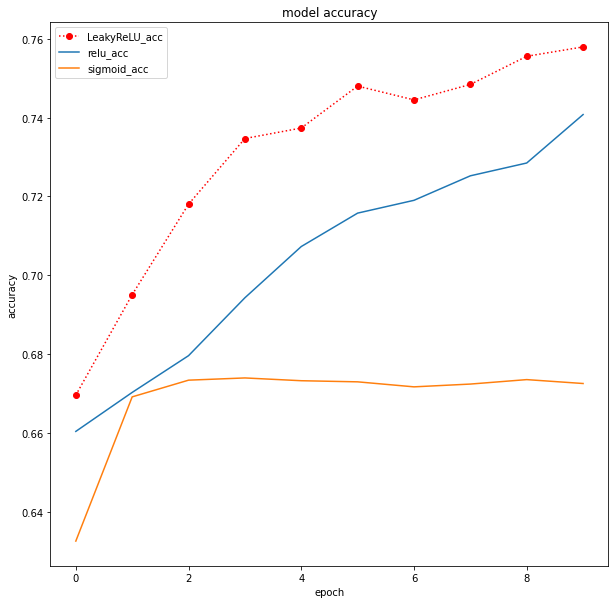

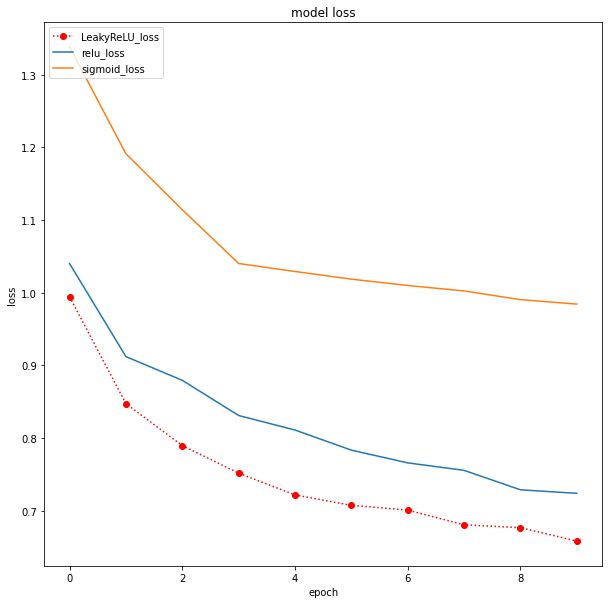

In [ ]:
plt.figure(figsize=(10, 10))
plt.plot(history_LeakyReLU.history['accuracy'] ,'o:r')
plt.plot(history_relu.history['accuracy'] )
plt.plot(history_sigmoid.history['accuracy'] )




plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['LeakyReLU_acc',"relu_acc","sigmoid_acc"], loc='upper left')
plt.show()
plt.figure(figsize=(10, 10))
plt.plot(history_LeakyReLU.history['loss'],'o:r')
plt.plot(history_relu.history['loss'])
plt.plot(history_sigmoid.history['loss'])





plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['LeakyReLU_loss',"relu_loss" ,"sigmoid_loss"], loc='upper left')
plt.show()

# tanh

In [ ]:
input_shape = (32, 32, 3)
num_classes = 7

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),activation='tanh',padding = 'Same',input_shape=input_shape))
model.add(Conv2D(32,kernel_size=(3, 3), activation='tanh',padding = 'Same',))
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='tanh',padding = 'Same'))
model.add(Conv2D(64, (3, 3), activation='tanh',padding = 'Same'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.40))

model.add(Flatten())
model.add(Dense(128, activation='tanh'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))
model.summary()


# Define the optimizer
optimizer = Adam(lr=0.001)
# Compile the model
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])


# Fit the model
epochs = 10 
batch_size = 128
history_tanh= model.fit_generator(datagen.flow(x_train,y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (x_validate,y_validate),
                              verbose = 1, steps_per_epoch=x_train.shape[0] // batch_size
                              , callbacks=[reduce_lr,checkpoint])

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 conv2d_13 (Conv2D)          (None, 32, 32, 32)        9248      
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 dropout_9 (Dropout)         (None, 16, 16, 32)        0         
                                                                 
 conv2d_14 (Conv2D)          (None, 16, 16, 64)        18496     
                                                                 
 conv2d_15 (Conv2D)          (None, 16, 16, 64)        36928     
                                                      

<ipython-input-61-ef63cf1ed850>:31: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history_tanh= model.fit_generator(datagen.flow(x_train,y_train, batch_size=batch_size),


Epoch 1/10
56/56 [==============================] - ETA: 0s - loss: 1.0874 - accuracy: 0.6402

56/56 [==============================] - 40s 693ms/step - loss: 1.0874 - accuracy: 0.6402 - val_loss: 1.3324 - val_accuracy: 0.5050 - lr: 0.0010
Epoch 2/10
56/56 [==============================] - ETA: 0s - loss: 0.8825 - accuracy: 0.6803

56/56 [==============================] - 40s 706ms/step - loss: 0.8825 - accuracy: 0.6803 - val_loss: 0.9477 - val_accuracy: 0.6421 - lr: 0.0010
Epoch 3/10
56/56 [==============================] - ETA: 0s - loss: 0.8083 - accuracy: 0.7151

56/56 [==============================] - 39s 687ms/step - loss: 0.8083 - accuracy: 0.7151 - val_loss: 0.9208 - val_accuracy: 0.6459 - lr: 0.0010
Epoch 4/10
56/56 [==============================] - ETA: 0s - loss: 0.7915 - accuracy: 0.7199

56/56 [==============================] - 41s 737ms/step - loss: 0.7915 - accuracy: 0.7199 - val_loss: 1.2109 - val_accuracy: 0.5461 - lr: 0.0010
Epoch 5/10
56/56 [==============================] - ETA: 0s - loss: 0.7922 - accuracy: 0.7182

56/56 [==============================] - 38s 685ms/step - loss: 0.7922 - accuracy: 0.7182 - val_loss: 0.9854 - val_accuracy: 0.6309 - lr: 0.0010
Epoch 6/10
56/56 [==============================] - ETA: 0s - loss: 0.7643 - accuracy: 0.7217

56/56 [==============================] - 39s 688ms/step - loss: 0.7643 - accuracy: 0.7217 - val_loss: 1.0157 - val_accuracy: 0.6185 - lr: 0.0010
Epoch 7/10
56/56 [==============================] - ETA: 0s - loss: 0.7454 - accuracy: 0.7357

56/56 [==============================] - 39s 692ms/step - loss: 0.7454 - accuracy: 0.7357 - val_loss: 0.9204 - val_accuracy: 0.6496 - lr: 0.0010
Epoch 8/10
56/56 [==============================] - ETA: 0s - loss: 0.7581 - accuracy: 0.7313

56/56 [==============================] - 40s 712ms/step - loss: 0.7581 - accuracy: 0.7313 - val_loss: 0.8775 - val_accuracy: 0.6845 - lr: 0.0010
Epoch 9/10
56/56 [==============================] - ETA: 0s - loss: 0.7225 - accuracy: 0.7447

56/56 [==============================] - 42s 748ms/step - loss: 0.7225 - accuracy: 0.7447 - val_loss: 0.8358 - val_accuracy: 0.6708 - lr: 0.0010
Epoch 10/10
56/56 [==============================] - ETA: 0s - loss: 0.7214 - accuracy: 0.7443

56/56 [==============================] - 51s 919ms/step - loss: 0.7214 - accuracy: 0.7443 - val_loss: 0.8563 - val_accuracy: 0.6608 - lr: 0.0010


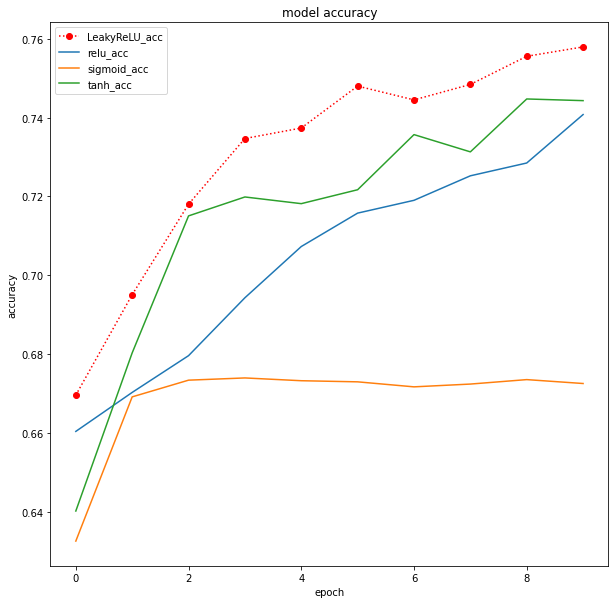

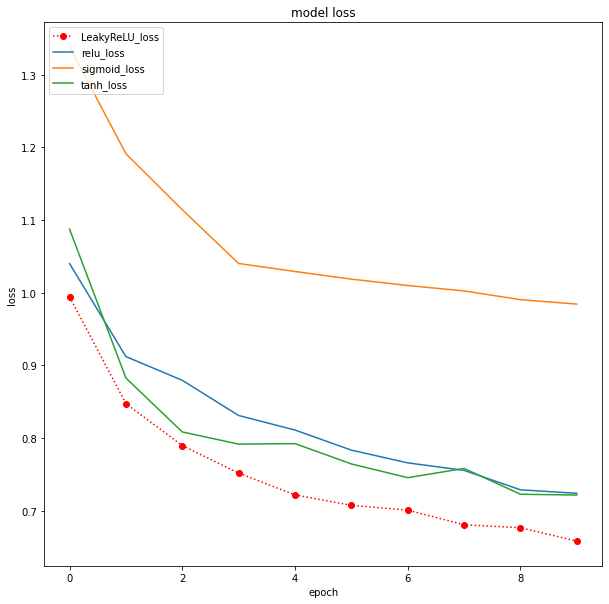

In [ ]:
plt.figure(figsize=(10, 10))
plt.plot(history_LeakyReLU.history['accuracy'] ,'o:r')
plt.plot(history_relu.history['accuracy'] )
plt.plot(history_sigmoid.history['accuracy'] )
plt.plot(history_tanh.history['accuracy'] )




plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['LeakyReLU_acc',"relu_acc","sigmoid_acc","tanh_acc"], loc='upper left')
plt.show()
plt.figure(figsize=(10, 10))
plt.plot(history_LeakyReLU.history['loss'],'o:r')
plt.plot(history_relu.history['loss'])
plt.plot(history_sigmoid.history['loss'])
plt.plot(history_tanh.history['loss'])






plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['LeakyReLU_loss',"relu_loss" ,"sigmoid_loss","tanh_loss"], loc='upper left')
plt.show()

In [ ]:
input_shape = (32, 32, 3)
num_classes = 7

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),activation='elu',padding = 'Same',input_shape=input_shape))
model.add(Conv2D(32,kernel_size=(3, 3), activation='elu',padding = 'Same',))
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='elu',padding = 'Same'))
model.add(Conv2D(64, (3, 3), activation='elu',padding = 'Same'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.40))

model.add(Flatten())
model.add(Dense(128, activation='elu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))
model.summary()


# Define the optimizer
optimizer = Adam(lr=0.001)
# Compile the model
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])


# Fit the model
epochs = 10 
batch_size = 128
history_elu= model.fit_generator(datagen.flow(x_train,y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (x_validate,y_validate),
                              verbose = 1, steps_per_epoch=x_train.shape[0] // batch_size
                              , callbacks=[reduce_lr,checkpoint])

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 conv2d_17 (Conv2D)          (None, 32, 32, 32)        9248      
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 dropout_12 (Dropout)        (None, 16, 16, 32)        0         
                                                                 
 conv2d_18 (Conv2D)          (None, 16, 16, 64)        18496     
                                                                 
 conv2d_19 (Conv2D)          (None, 16, 16, 64)        36928     
                                                      

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
<ipython-input-63-c7b4e64e791a>:31: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history_elu= model.fit_generator(datagen.flow(x_train,y_train, batch_size=batch_size),


Epoch 1/10
56/56 [==============================] - ETA: 0s - loss: 1.0468 - accuracy: 0.6525

56/56 [==============================] - 42s 725ms/step - loss: 1.0468 - accuracy: 0.6525 - val_loss: 0.9680 - val_accuracy: 0.6509 - lr: 0.0010
Epoch 2/10
56/56 [==============================] - ETA: 0s - loss: 0.8552 - accuracy: 0.6940

56/56 [==============================] - 41s 725ms/step - loss: 0.8552 - accuracy: 0.6940 - val_loss: 0.9934 - val_accuracy: 0.6297 - lr: 0.0010
Epoch 3/10
56/56 [==============================] - ETA: 0s - loss: 0.8129 - accuracy: 0.7101

56/56 [==============================] - 44s 778ms/step - loss: 0.8129 - accuracy: 0.7101 - val_loss: 0.9276 - val_accuracy: 0.6646 - lr: 0.0010
Epoch 4/10
56/56 [==============================] - ETA: 0s - loss: 0.7943 - accuracy: 0.7151

56/56 [==============================] - 41s 727ms/step - loss: 0.7943 - accuracy: 0.7151 - val_loss: 0.8622 - val_accuracy: 0.6708 - lr: 0.0010
Epoch 5/10
56/56 [==============================] - ETA: 0s - loss: 0.7874 - accuracy: 0.7149

56/56 [==============================] - 41s 729ms/step - loss: 0.7874 - accuracy: 0.7149 - val_loss: 0.8752 - val_accuracy: 0.6696 - lr: 0.0010
Epoch 6/10
56/56 [==============================] - ETA: 0s - loss: 0.7725 - accuracy: 0.7214

56/56 [==============================] - 41s 727ms/step - loss: 0.7725 - accuracy: 0.7214 - val_loss: 0.8174 - val_accuracy: 0.6995 - lr: 0.0010
Epoch 7/10
56/56 [==============================] - ETA: 0s - loss: 0.7439 - accuracy: 0.7338

56/56 [==============================] - 57s 1s/step - loss: 0.7439 - accuracy: 0.7338 - val_loss: 0.8674 - val_accuracy: 0.6845 - lr: 0.0010
Epoch 8/10
56/56 [==============================] - ETA: 0s - loss: 0.7293 - accuracy: 0.7382

56/56 [==============================] - 41s 733ms/step - loss: 0.7293 - accuracy: 0.7382 - val_loss: 0.8253 - val_accuracy: 0.6945 - lr: 0.0010
Epoch 9/10
56/56 [==============================] - ETA: 0s - loss: 0.7179 - accuracy: 0.7395

56/56 [==============================] - 41s 728ms/step - loss: 0.7179 - accuracy: 0.7395 - val_loss: 0.8825 - val_accuracy: 0.6496 - lr: 0.0010
Epoch 10/10
56/56 [==============================] - ETA: 0s - loss: 0.7294 - accuracy: 0.7358

56/56 [==============================] - 47s 846ms/step - loss: 0.7294 - accuracy: 0.7358 - val_loss: 0.8152 - val_accuracy: 0.7082 - lr: 0.0010


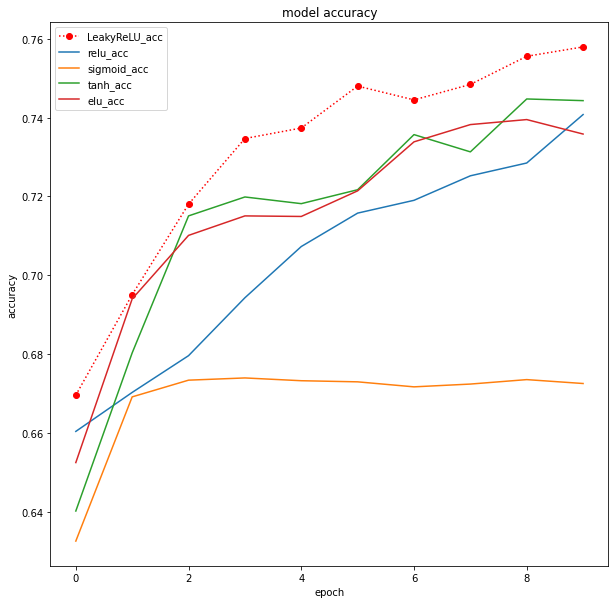

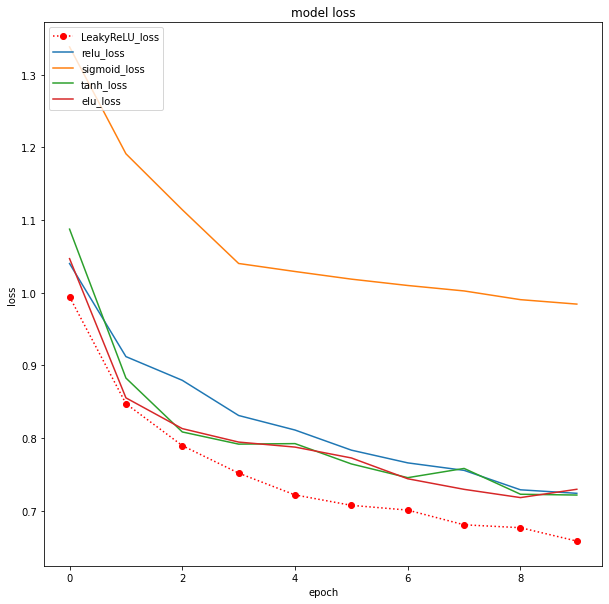

In [ ]:
plt.figure(figsize=(10, 10))
plt.plot(history_LeakyReLU.history['accuracy'] ,'o:r')
plt.plot(history_relu.history['accuracy'] )
plt.plot(history_sigmoid.history['accuracy'] )
plt.plot(history_tanh.history['accuracy'] )
plt.plot(history_elu.history['accuracy'] )




plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['LeakyReLU_acc',"relu_acc","sigmoid_acc","tanh_acc","elu_acc"], loc='upper left')
plt.show()
plt.figure(figsize=(10, 10))
plt.plot(history_LeakyReLU.history['loss'],'o:r')
plt.plot(history_relu.history['loss'])
plt.plot(history_sigmoid.history['loss'])
plt.plot(history_tanh.history['loss'])
plt.plot(history_elu.history['loss'])






plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['LeakyReLU_loss',"relu_loss" ,"sigmoid_loss","tanh_loss","elu_loss"], loc='upper left')
plt.show()

In [ ]:
input_shape = (32, 32, 3)
num_classes = 7

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),activation='linear',padding = 'Same',input_shape=input_shape))
model.add(Conv2D(32,kernel_size=(3, 3), activation='linear',padding = 'Same',))
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='linear',padding = 'Same'))
model.add(Conv2D(64, (3, 3), activation='linear',padding = 'Same'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.40))

model.add(Flatten())
model.add(Dense(128, activation='linear'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))
model.summary()


# Define the optimizer
optimizer = Adam(lr=0.001)
# Compile the model
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])


# Fit the model
epochs = 10 
batch_size = 128
history_linear= model.fit_generator(datagen.flow(x_train,y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (x_validate,y_validate),
                              verbose = 1, steps_per_epoch=x_train.shape[0] // batch_size
                              , callbacks=[reduce_lr,checkpoint])

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_24 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 conv2d_25 (Conv2D)          (None, 32, 32, 32)        9248      
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 16, 16, 32)       0         
 g2D)                                                            
                                                                 
 dropout_18 (Dropout)        (None, 16, 16, 32)        0         
                                                                 
 conv2d_26 (Conv2D)          (None, 16, 16, 64)        18496     
                                                                 
 conv2d_27 (Conv2D)          (None, 16, 16, 64)        36928     
                                                      

<ipython-input-67-fcdb1b741e6c>:31: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history_linear= model.fit_generator(datagen.flow(x_train,y_train, batch_size=batch_size),


56/56 [==============================] - ETA: 0s - loss: 1.2523 - accuracy: 0.6316

56/56 [==============================] - 48s 846ms/step - loss: 1.2523 - accuracy: 0.6316 - val_loss: 1.1324 - val_accuracy: 0.6047 - lr: 0.0010
Epoch 2/10
56/56 [==============================] - ETA: 0s - loss: 0.8828 - accuracy: 0.6862

56/56 [==============================] - 40s 708ms/step - loss: 0.8828 - accuracy: 0.6862 - val_loss: 1.4163 - val_accuracy: 0.5150 - lr: 0.0010
Epoch 3/10
56/56 [==============================] - ETA: 0s - loss: 0.8513 - accuracy: 0.6951

56/56 [==============================] - 38s 684ms/step - loss: 0.8513 - accuracy: 0.6951 - val_loss: 0.9773 - val_accuracy: 0.6496 - lr: 0.0010
Epoch 4/10
56/56 [==============================] - ETA: 0s - loss: 0.8132 - accuracy: 0.7134

56/56 [==============================] - 40s 708ms/step - loss: 0.8132 - accuracy: 0.7134 - val_loss: 1.3013 - val_accuracy: 0.5424 - lr: 0.0010
Epoch 5/10
56/56 [==============================] - ETA: 0s - loss: 0.8019 - accuracy: 0.7146

56/56 [==============================] - 38s 669ms/step - loss: 0.8019 - accuracy: 0.7146 - val_loss: 2.0398 - val_accuracy: 0.3067 - lr: 0.0010
Epoch 6/10
56/56 [==============================] - ETA: 0s - loss: 0.8028 - accuracy: 0.7043

56/56 [==============================] - 38s 675ms/step - loss: 0.8028 - accuracy: 0.7043 - val_loss: 1.0679 - val_accuracy: 0.6135 - lr: 0.0010
Epoch 7/10
56/56 [==============================] - ETA: 0s - loss: 0.7634 - accuracy: 0.7262

56/56 [==============================] - 38s 672ms/step - loss: 0.7634 - accuracy: 0.7262 - val_loss: 1.0992 - val_accuracy: 0.5973 - lr: 0.0010
Epoch 8/10
56/56 [==============================] - ETA: 0s - loss: 0.7493 - accuracy: 0.7306

56/56 [==============================] - 38s 674ms/step - loss: 0.7493 - accuracy: 0.7306 - val_loss: 1.2975 - val_accuracy: 0.5324 - lr: 0.0010
Epoch 9/10
56/56 [==============================] - ETA: 0s - loss: 0.7451 - accuracy: 0.7316

56/56 [==============================] - 39s 697ms/step - loss: 0.7451 - accuracy: 0.7316 - val_loss: 1.6434 - val_accuracy: 0.4738 - lr: 0.0010
Epoch 10/10
56/56 [==============================] - ETA: 0s - loss: 0.7457 - accuracy: 0.7350

56/56 [==============================] - 38s 683ms/step - loss: 0.7457 - accuracy: 0.7350 - val_loss: 1.2324 - val_accuracy: 0.5586 - lr: 0.0010


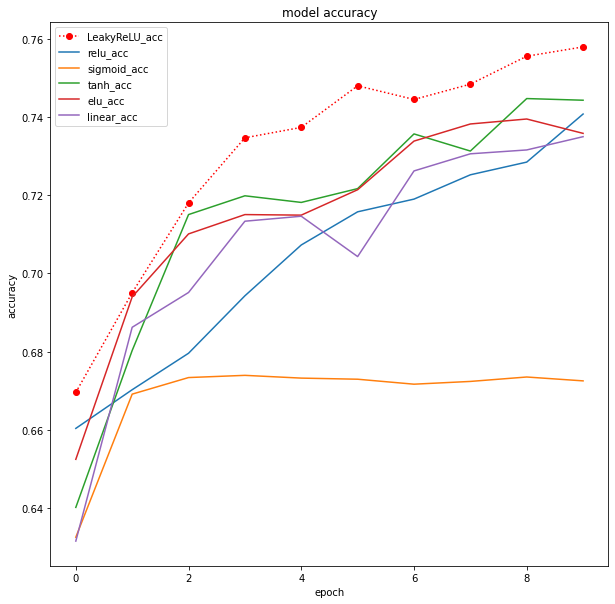

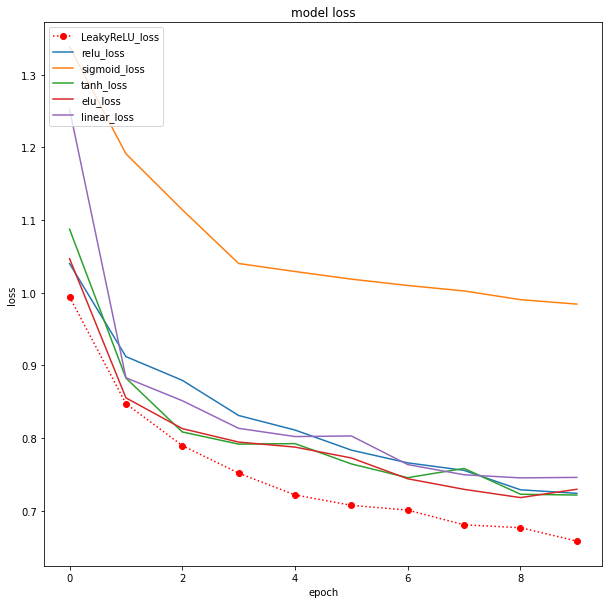

In [ ]:
plt.figure(figsize=(10, 10))
plt.plot(history_LeakyReLU.history['accuracy'] ,'o:r')
plt.plot(history_relu.history['accuracy'] )
plt.plot(history_sigmoid.history['accuracy'] )
plt.plot(history_tanh.history['accuracy'] )
plt.plot(history_elu.history['accuracy'] )
plt.plot(history_linear.history['accuracy'] )




plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['LeakyReLU_acc',"relu_acc","sigmoid_acc","tanh_acc","elu_acc","linear_acc"], loc='upper left')
plt.show()
plt.figure(figsize=(10, 10))
plt.plot(history_LeakyReLU.history['loss'],'o:r')
plt.plot(history_relu.history['loss'])
plt.plot(history_sigmoid.history['loss'])
plt.plot(history_tanh.history['loss'])
plt.plot(history_elu.history['loss'])
plt.plot(history_linear.history['loss'])






plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['LeakyReLU_loss',"relu_loss" ,"sigmoid_loss","tanh_loss","elu_loss","linear_loss"], loc='upper left')
plt.show()

In [ ]:
input_shape = (32, 32, 3)
num_classes = 7

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),activation='softplus',padding = 'Same',input_shape=input_shape))
model.add(Conv2D(32,kernel_size=(3, 3), activation='softplus',padding = 'Same',))
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='softplus',padding = 'Same'))
model.add(Conv2D(64, (3, 3), activation='softplus',padding = 'Same'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.40))

model.add(Flatten())
model.add(Dense(128, activation='softplus'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))
model.summary()


# Define the optimizer
optimizer = Adam(lr=0.001)
# Compile the model
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])


# Fit the model
epochs = 10 
batch_size = 128
history_softplus= model.fit_generator(datagen.flow(x_train,y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (x_validate,y_validate),
                              verbose = 1, steps_per_epoch=x_train.shape[0] // batch_size
                              , callbacks=[reduce_lr,checkpoint])

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_28 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 conv2d_29 (Conv2D)          (None, 32, 32, 32)        9248      
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 16, 16, 32)       0         
 g2D)                                                            
                                                                 
 dropout_21 (Dropout)        (None, 16, 16, 32)        0         
                                                                 
 conv2d_30 (Conv2D)          (None, 16, 16, 64)        18496     
                                                                 
 conv2d_31 (Conv2D)          (None, 16, 16, 64)        36928     
                                                      

<ipython-input-69-1a6c06731b94>:31: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history_softplus= model.fit_generator(datagen.flow(x_train,y_train, batch_size=batch_size),


Epoch 1/10
56/56 [==============================] - ETA: 0s - loss: 1.4772 - accuracy: 0.6357

56/56 [==============================] - 46s 804ms/step - loss: 1.4772 - accuracy: 0.6357 - val_loss: 1.1948 - val_accuracy: 0.6434 - lr: 0.0010
Epoch 2/10
56/56 [==============================] - ETA: 0s - loss: 1.1788 - accuracy: 0.6727

56/56 [==============================] - 46s 827ms/step - loss: 1.1788 - accuracy: 0.6727 - val_loss: 1.1860 - val_accuracy: 0.6434 - lr: 0.0010
Epoch 3/10
56/56 [==============================] - ETA: 0s - loss: 1.1303 - accuracy: 0.6723

56/56 [==============================] - 45s 799ms/step - loss: 1.1303 - accuracy: 0.6723 - val_loss: 1.1047 - val_accuracy: 0.6434 - lr: 0.0010
Epoch 4/10
56/56 [==============================] - ETA: 0s - loss: 1.0494 - accuracy: 0.6713

56/56 [==============================] - 45s 805ms/step - loss: 1.0494 - accuracy: 0.6713 - val_loss: 1.0771 - val_accuracy: 0.6434 - lr: 0.0010
Epoch 5/10
56/56 [==============================] - ETA: 0s - loss: 1.0020 - accuracy: 0.6707

56/56 [==============================] - 46s 822ms/step - loss: 1.0020 - accuracy: 0.6707 - val_loss: 0.9987 - val_accuracy: 0.6434 - lr: 0.0010
Epoch 6/10
56/56 [==============================] - ETA: 0s - loss: 0.9716 - accuracy: 0.6711

56/56 [==============================] - 45s 795ms/step - loss: 0.9716 - accuracy: 0.6711 - val_loss: 1.0069 - val_accuracy: 0.6434 - lr: 0.0010
Epoch 7/10
56/56 [==============================] - ETA: 0s - loss: 0.9483 - accuracy: 0.6733

56/56 [==============================] - 44s 802ms/step - loss: 0.9483 - accuracy: 0.6733 - val_loss: 0.9989 - val_accuracy: 0.6434 - lr: 0.0010
Epoch 8/10
56/56 [==============================] - ETA: 0s - loss: 0.9308 - accuracy: 0.6689

56/56 [==============================] - 57s 1s/step - loss: 0.9308 - accuracy: 0.6689 - val_loss: 0.9386 - val_accuracy: 0.6446 - lr: 0.0010
Epoch 9/10
56/56 [==============================] - ETA: 0s - loss: 0.9194 - accuracy: 0.6707

56/56 [==============================] - 45s 801ms/step - loss: 0.9194 - accuracy: 0.6707 - val_loss: 0.9533 - val_accuracy: 0.6421 - lr: 0.0010
Epoch 10/10
56/56 [==============================] - ETA: 0s - loss: 0.9067 - accuracy: 0.6715

56/56 [==============================] - 47s 829ms/step - loss: 0.9067 - accuracy: 0.6715 - val_loss: 0.9351 - val_accuracy: 0.6446 - lr: 0.0010


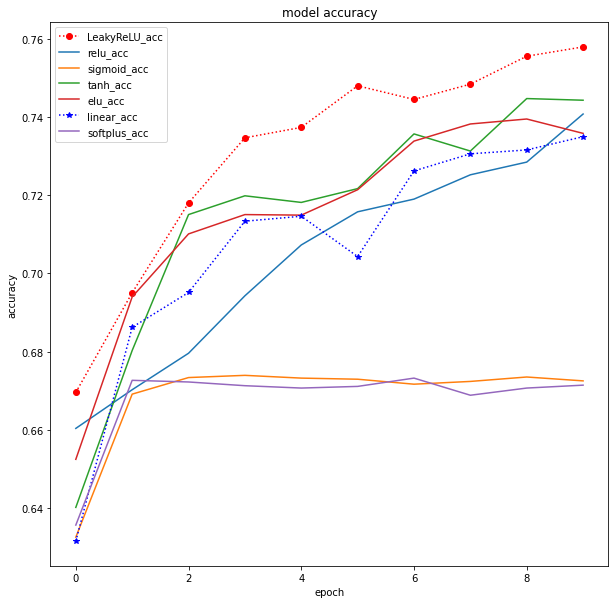

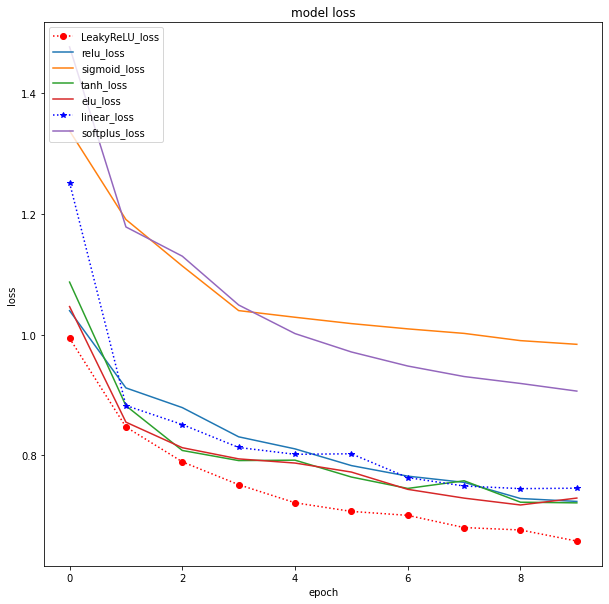

In [ ]:
plt.figure(figsize=(10, 10))
plt.plot(history_LeakyReLU.history['accuracy'] ,'o:r')
plt.plot(history_relu.history['accuracy'] )
plt.plot(history_sigmoid.history['accuracy'] )
plt.plot(history_tanh.history['accuracy'] )
plt.plot(history_elu.history['accuracy'] )
plt.plot(history_linear.history['accuracy'],'*:b' )
plt.plot(history_softplus.history['accuracy'] )




plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['LeakyReLU_acc',"relu_acc","sigmoid_acc","tanh_acc","elu_acc","linear_acc","softplus_acc"], loc='upper left')
plt.show()
plt.figure(figsize=(10, 10))
plt.plot(history_LeakyReLU.history['loss'],'o:r')
plt.plot(history_relu.history['loss'])
plt.plot(history_sigmoid.history['loss'])
plt.plot(history_tanh.history['loss'])
plt.plot(history_elu.history['loss'])
plt.plot(history_linear.history['loss'],'*:b')
plt.plot(history_softplus.history['loss'])






plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['LeakyReLU_loss',"relu_loss" ,"sigmoid_loss","tanh_loss","elu_loss","linear_loss","softplus_loss"], loc='upper left')
plt.show()

In [ ]:
history_softplus

In [ ]:
input_shape = (32, 32, 3)
num_classes = 7

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),activation='swish',padding = 'Same',input_shape=input_shape))
model.add(Conv2D(32,kernel_size=(3, 3), activation='swish',padding = 'Same',))
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='swish',padding = 'Same'))
model.add(Conv2D(64, (3, 3), activation='swish',padding = 'Same'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.40))

model.add(Flatten())
model.add(Dense(128, activation='swish'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))
model.summary()


# Define the optimizer
optimizer = Adam(lr=0.001)
# Compile the model
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])


# Fit the model
epochs = 10 
batch_size = 128
history_swishs= model.fit_generator(datagen.flow(x_train,y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (x_validate,y_validate),
                              verbose = 1, steps_per_epoch=x_train.shape[0] // batch_size
                              , callbacks=[reduce_lr,checkpoint])

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_32 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 conv2d_33 (Conv2D)          (None, 32, 32, 32)        9248      
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 16, 16, 32)       0         
 g2D)                                                            
                                                                 
 dropout_24 (Dropout)        (None, 16, 16, 32)        0         
                                                                 
 conv2d_34 (Conv2D)          (None, 16, 16, 64)        18496     
                                                                 
 conv2d_35 (Conv2D)          (None, 16, 16, 64)        36928     
                                                      

<ipython-input-77-98b80b4747a9>:31: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history_swishs= model.fit_generator(datagen.flow(x_train,y_train, batch_size=batch_size),


56/56 [==============================] - ETA: 0s - loss: 1.0483 - accuracy: 0.6563

56/56 [==============================] - 43s 759ms/step - loss: 1.0483 - accuracy: 0.6563 - val_loss: 0.9869 - val_accuracy: 0.6471 - lr: 0.0010
Epoch 2/10
56/56 [==============================] - ETA: 0s - loss: 0.8980 - accuracy: 0.6793

56/56 [==============================] - 43s 763ms/step - loss: 0.8980 - accuracy: 0.6793 - val_loss: 0.8900 - val_accuracy: 0.6521 - lr: 0.0010
Epoch 3/10
56/56 [==============================] - ETA: 0s - loss: 0.8252 - accuracy: 0.7014

56/56 [==============================] - 46s 822ms/step - loss: 0.8252 - accuracy: 0.7014 - val_loss: 0.8780 - val_accuracy: 0.6746 - lr: 0.0010
Epoch 4/10
56/56 [==============================] - ETA: 0s - loss: 0.7986 - accuracy: 0.7073

56/56 [==============================] - 44s 793ms/step - loss: 0.7986 - accuracy: 0.7073 - val_loss: 0.8415 - val_accuracy: 0.6945 - lr: 0.0010
Epoch 5/10
56/56 [==============================] - ETA: 0s - loss: 0.7560 - accuracy: 0.7255

56/56 [==============================] - 69s 1s/step - loss: 0.7560 - accuracy: 0.7255 - val_loss: 0.8161 - val_accuracy: 0.6845 - lr: 0.0010
Epoch 6/10
56/56 [==============================] - ETA: 0s - loss: 0.7423 - accuracy: 0.7314

56/56 [==============================] - 44s 781ms/step - loss: 0.7423 - accuracy: 0.7314 - val_loss: 0.7803 - val_accuracy: 0.7057 - lr: 0.0010
Epoch 7/10
56/56 [==============================] - ETA: 0s - loss: 0.7231 - accuracy: 0.7361

56/56 [==============================] - 45s 804ms/step - loss: 0.7231 - accuracy: 0.7361 - val_loss: 0.8085 - val_accuracy: 0.7032 - lr: 0.0010
Epoch 8/10
56/56 [==============================] - ETA: 0s - loss: 0.7151 - accuracy: 0.7416

56/56 [==============================] - 43s 761ms/step - loss: 0.7151 - accuracy: 0.7416 - val_loss: 0.7867 - val_accuracy: 0.6883 - lr: 0.0010
Epoch 9/10
56/56 [==============================] - ETA: 0s - loss: 0.6898 - accuracy: 0.7488

56/56 [==============================] - 43s 759ms/step - loss: 0.6898 - accuracy: 0.7488 - val_loss: 0.7680 - val_accuracy: 0.6908 - lr: 0.0010
Epoch 10/10
56/56 [==============================] - ETA: 0s - loss: 0.6857 - accuracy: 0.7429

56/56 [==============================] - 44s 781ms/step - loss: 0.6857 - accuracy: 0.7429 - val_loss: 0.7676 - val_accuracy: 0.6983 - lr: 0.0010


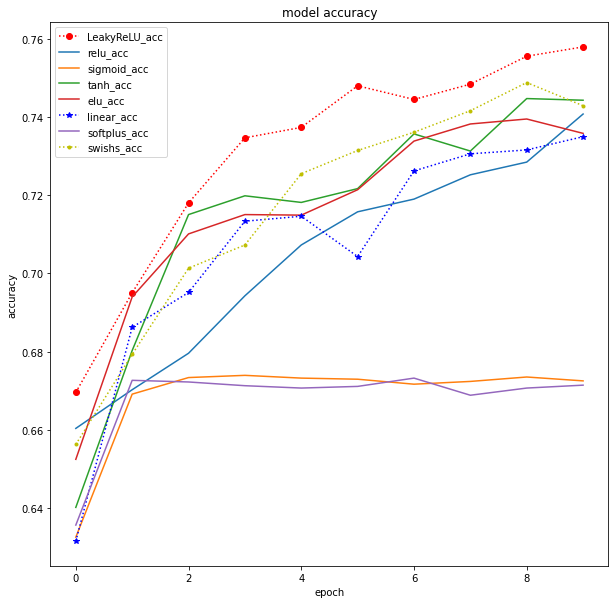

_________________________________________________________________________________________________________________________________________________________________________________


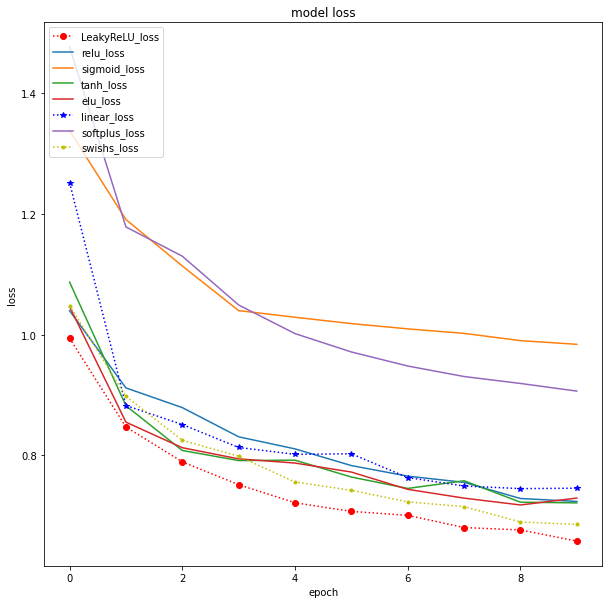

In [ ]:
plt.figure(figsize=(10, 10))
plt.plot(history_LeakyReLU.history['accuracy'] ,'o:r')
plt.plot(history_relu.history['accuracy'] )
plt.plot(history_sigmoid.history['accuracy'] )
plt.plot(history_tanh.history['accuracy'] )
plt.plot(history_elu.history['accuracy'] )
plt.plot(history_linear.history['accuracy'],'*:b' )
plt.plot(history_softplus.history['accuracy'] )
plt.plot(history_swishs.history['accuracy'],'.:y' )




plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['LeakyReLU_acc',"relu_acc","sigmoid_acc","tanh_acc","elu_acc","linear_acc","softplus_acc","swishs_acc"], loc='upper left')
plt.show()



print("_________________________________________________________________________________________________________________________________________________________________________________")




plt.figure(figsize=(10, 10))
plt.plot(history_LeakyReLU.history['loss'],'o:r')
plt.plot(history_relu.history['loss'])
plt.plot(history_sigmoid.history['loss'])
plt.plot(history_tanh.history['loss'])
plt.plot(history_elu.history['loss'])
plt.plot(history_linear.history['loss'],'*:b')
plt.plot(history_softplus.history['loss'])
plt.plot(history_swishs.history['loss'],'.:y')






plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['LeakyReLU_loss',"relu_loss" ,"sigmoid_loss","tanh_loss","elu_loss","linear_loss","softplus_loss","swishs_loss"], loc='upper left')
plt.show()

In [ ]:
import tensorflow as tf


In [ ]:
input_shape = (32, 32, 3)
num_classes = 7

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),activation=tf.math.sin,padding = 'Same',input_shape=input_shape))
model.add(Conv2D(32,kernel_size=(3, 3), activation=tf.math.sin,padding = 'Same',))
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation=tf.math.sin,padding = 'Same'))
model.add(Conv2D(64, (3, 3), activation=tf.math.sin,padding = 'Same'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.40))

model.add(Flatten())
model.add(Dense(128, activation=tf.math.sin))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))
model.summary()


# Define the optimizer
optimizer = Adam(lr=0.001)
# Compile the model
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])


# Fit the model
epochs = 10 
batch_size = 128
history_siren= model.fit_generator(datagen.flow(x_train,y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (x_validate,y_validate),
                              verbose = 1, steps_per_epoch=x_train.shape[0] // batch_size
                              , callbacks=[reduce_lr,checkpoint])

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_40 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 conv2d_41 (Conv2D)          (None, 32, 32, 32)        9248      
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, 16, 16, 32)       0         
 g2D)                                                            
                                                                 
 dropout_30 (Dropout)        (None, 16, 16, 32)        0         
                                                                 
 conv2d_42 (Conv2D)          (None, 16, 16, 64)        18496     
                                                                 
 conv2d_43 (Conv2D)          (None, 16, 16, 64)        36928     
                                                     

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
<ipython-input-87-57ef51b46547>:31: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history_siren= model.fit_generator(datagen.flow(x_train,y_train, batch_size=batch_size),


56/56 [==============================] - ETA: 0s - loss: 1.0610 - accuracy: 0.6480

56/56 [==============================] - 41s 714ms/step - loss: 1.0610 - accuracy: 0.6480 - val_loss: 1.0671 - val_accuracy: 0.6284 - lr: 0.0010
Epoch 2/10
56/56 [==============================] - ETA: 0s - loss: 0.8622 - accuracy: 0.6995

56/56 [==============================] - 43s 761ms/step - loss: 0.8622 - accuracy: 0.6995 - val_loss: 1.0569 - val_accuracy: 0.5998 - lr: 0.0010
Epoch 3/10
56/56 [==============================] - ETA: 0s - loss: 0.8223 - accuracy: 0.7081

56/56 [==============================] - 43s 765ms/step - loss: 0.8223 - accuracy: 0.7081 - val_loss: 1.0281 - val_accuracy: 0.6035 - lr: 0.0010
Epoch 4/10
56/56 [==============================] - ETA: 0s - loss: 0.7935 - accuracy: 0.7145

56/56 [==============================] - 41s 724ms/step - loss: 0.7935 - accuracy: 0.7145 - val_loss: 0.8539 - val_accuracy: 0.7007 - lr: 0.0010
Epoch 5/10
56/56 [==============================] - ETA: 0s - loss: 0.7866 - accuracy: 0.7190

56/56 [==============================] - 40s 720ms/step - loss: 0.7866 - accuracy: 0.7190 - val_loss: 0.9542 - val_accuracy: 0.6521 - lr: 0.0010
Epoch 6/10
56/56 [==============================] - ETA: 0s - loss: 0.7572 - accuracy: 0.7247

56/56 [==============================] - 40s 721ms/step - loss: 0.7572 - accuracy: 0.7247 - val_loss: 0.8589 - val_accuracy: 0.6758 - lr: 0.0010
Epoch 7/10
56/56 [==============================] - ETA: 0s - loss: 0.7507 - accuracy: 0.7327

56/56 [==============================] - 42s 741ms/step - loss: 0.7507 - accuracy: 0.7327 - val_loss: 0.8632 - val_accuracy: 0.6908 - lr: 0.0010
Epoch 8/10
56/56 [==============================] - ETA: 0s - loss: 0.7366 - accuracy: 0.7392

56/56 [==============================] - 40s 720ms/step - loss: 0.7366 - accuracy: 0.7392 - val_loss: 0.8406 - val_accuracy: 0.6858 - lr: 0.0010
Epoch 9/10
56/56 [==============================] - ETA: 0s - loss: 0.7080 - accuracy: 0.7420

56/56 [==============================] - 41s 727ms/step - loss: 0.7080 - accuracy: 0.7420 - val_loss: 0.9333 - val_accuracy: 0.6471 - lr: 0.0010
Epoch 10/10
56/56 [==============================] - ETA: 0s - loss: 0.7140 - accuracy: 0.7441

56/56 [==============================] - 41s 724ms/step - loss: 0.7140 - accuracy: 0.7441 - val_loss: 0.8810 - val_accuracy: 0.6746 - lr: 0.0010


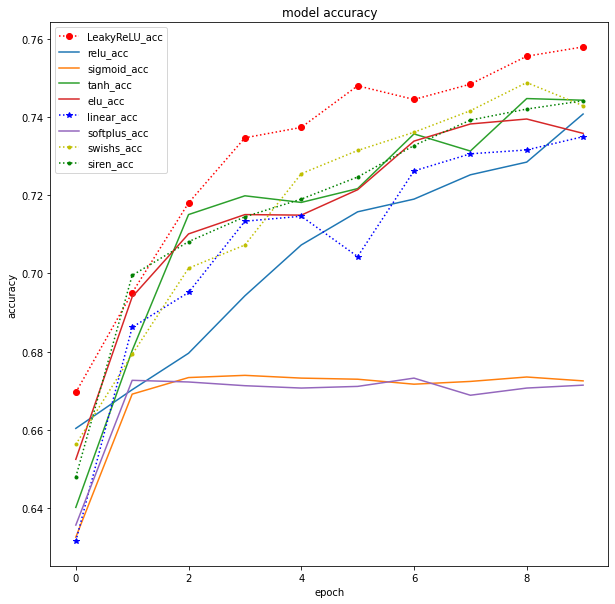

_________________________________________________________________________________________________________________________________________________________________________________


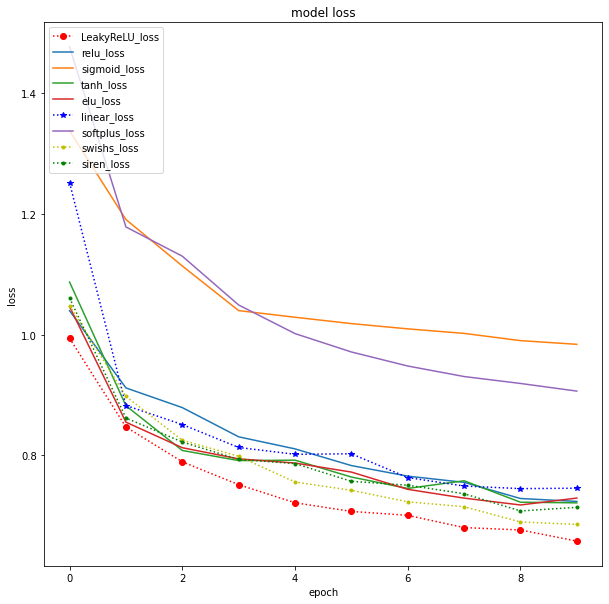

In [ ]:
plt.figure(figsize=(10, 10))
plt.plot(history_LeakyReLU.history['accuracy'] ,'o:r')
plt.plot(history_relu.history['accuracy'] )
plt.plot(history_sigmoid.history['accuracy'] )
plt.plot(history_tanh.history['accuracy'] )
plt.plot(history_elu.history['accuracy'] )
plt.plot(history_linear.history['accuracy'],'*:b' )
plt.plot(history_softplus.history['accuracy'] )
plt.plot(history_swishs.history['accuracy'],'.:y' )
plt.plot(history_siren.history['accuracy'],'.:g')




plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['LeakyReLU_acc',"relu_acc","sigmoid_acc","tanh_acc","elu_acc","linear_acc","softplus_acc","swishs_acc","siren_acc"], loc='upper left')
plt.show()



print("_________________________________________________________________________________________________________________________________________________________________________________")




plt.figure(figsize=(10, 10))
plt.plot(history_LeakyReLU.history['loss'],'o:r')
plt.plot(history_relu.history['loss'])
plt.plot(history_sigmoid.history['loss'])
plt.plot(history_tanh.history['loss'])
plt.plot(history_elu.history['loss'])
plt.plot(history_linear.history['loss'],'*:b')
plt.plot(history_softplus.history['loss'])
plt.plot(history_swishs.history['loss'],'.:y')
plt.plot(history_siren.history['loss'],'.:g')



history_siren


plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['LeakyReLU_loss',"relu_loss" ,"sigmoid_loss","tanh_loss","elu_loss","linear_loss","softplus_loss","swishs_loss","siren_loss"], loc='upper left')
plt.show()

In [ ]:
input_shape = (32, 32, 3)
num_classes = 7

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),activation="hard_sigmoid",padding = 'Same',input_shape=input_shape))
model.add(Conv2D(32,kernel_size=(3, 3), activation="hard_sigmoid",padding = 'Same',))
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation="hard_sigmoid",padding = 'Same'))
model.add(Conv2D(64, (3, 3), activation="hard_sigmoid",padding = 'Same'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.40))

model.add(Flatten())
model.add(Dense(128, activation="hard_sigmoid"))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))


# Define the optimizer
optimizer = Adam(lr=0.001)
# Compile the model
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])


# Fit the model
epochs = 10 
batch_size = 128
history_hard_sigmoid= model.fit_generator(datagen.flow(x_train,y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (x_validate,y_validate),
                              verbose = 1, steps_per_epoch=x_train.shape[0] // batch_size
                              , callbacks=[reduce_lr,checkpoint])

Epoch 1/10


<ipython-input-92-4b4cf25f1aa9>:30: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history_hard_sigmoid= model.fit_generator(datagen.flow(x_train,y_train, batch_size=batch_size),


56/56 [==============================] - ETA: 0s - loss: 1.2855 - accuracy: 0.6440

56/56 [==============================] - 47s 814ms/step - loss: 1.2855 - accuracy: 0.6440 - val_loss: 1.1993 - val_accuracy: 0.6434 - lr: 0.0010
Epoch 2/10
56/56 [==============================] - ETA: 0s - loss: 1.1663 - accuracy: 0.6717

56/56 [==============================] - 46s 824ms/step - loss: 1.1663 - accuracy: 0.6717 - val_loss: 1.1847 - val_accuracy: 0.6434 - lr: 0.0010
Epoch 3/10
56/56 [==============================] - ETA: 0s - loss: 1.0719 - accuracy: 0.6724

56/56 [==============================] - 44s 777ms/step - loss: 1.0719 - accuracy: 0.6724 - val_loss: 1.0618 - val_accuracy: 0.6434 - lr: 0.0010
Epoch 4/10
56/56 [==============================] - ETA: 0s - loss: 1.0296 - accuracy: 0.6730

56/56 [==============================] - 43s 780ms/step - loss: 1.0296 - accuracy: 0.6730 - val_loss: 1.0557 - val_accuracy: 0.6434 - lr: 0.0010
Epoch 5/10
56/56 [==============================] - ETA: 0s - loss: 1.0135 - accuracy: 0.6728

56/56 [==============================] - 45s 797ms/step - loss: 1.0135 - accuracy: 0.6728 - val_loss: 1.0522 - val_accuracy: 0.6434 - lr: 0.0010
Epoch 6/10
56/56 [==============================] - ETA: 0s - loss: 1.0014 - accuracy: 0.6734

56/56 [==============================] - 44s 777ms/step - loss: 1.0014 - accuracy: 0.6734 - val_loss: 1.0278 - val_accuracy: 0.6434 - lr: 0.0010
Epoch 7/10
56/56 [==============================] - ETA: 0s - loss: 0.9866 - accuracy: 0.6721

56/56 [==============================] - 44s 780ms/step - loss: 0.9866 - accuracy: 0.6721 - val_loss: 1.0147 - val_accuracy: 0.6434 - lr: 0.0010
Epoch 8/10
56/56 [==============================] - ETA: 0s - loss: 0.9798 - accuracy: 0.6735

56/56 [==============================] - 50s 912ms/step - loss: 0.9798 - accuracy: 0.6735 - val_loss: 1.0023 - val_accuracy: 0.6434 - lr: 0.0010
Epoch 9/10
56/56 [==============================] - ETA: 0s - loss: 0.9605 - accuracy: 0.6727

56/56 [==============================] - 60s 1s/step - loss: 0.9605 - accuracy: 0.6727 - val_loss: 1.0094 - val_accuracy: 0.6434 - lr: 0.0010
Epoch 10/10
56/56 [==============================] - ETA: 0s - loss: 0.9469 - accuracy: 0.6720

56/56 [==============================] - 43s 769ms/step - loss: 0.9469 - accuracy: 0.6720 - val_loss: 0.9740 - val_accuracy: 0.6434 - lr: 0.0010


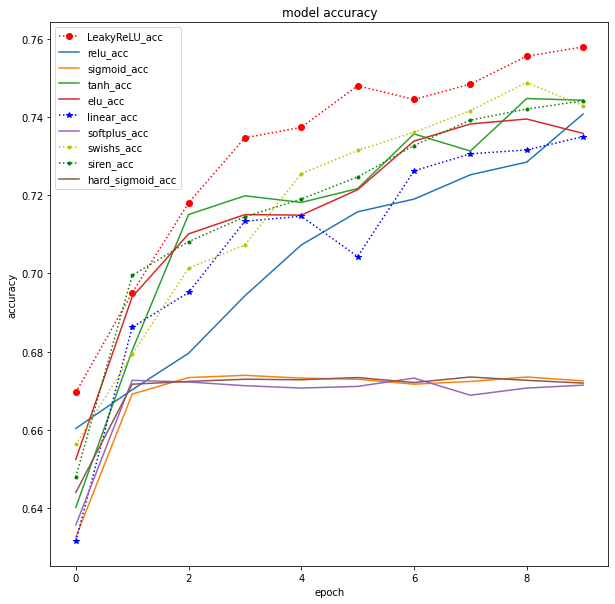

_________________________________________________________________________________________________________________________________________________________________________________


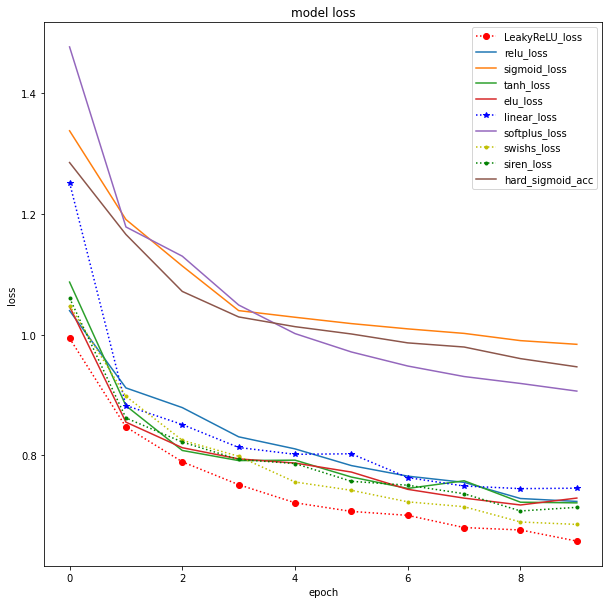

In [ ]:
plt.figure(figsize=(10, 10))
plt.plot(history_LeakyReLU.history['accuracy'] ,'o:r')
plt.plot(history_relu.history['accuracy'] )
plt.plot(history_sigmoid.history['accuracy'] )
plt.plot(history_tanh.history['accuracy'] )
plt.plot(history_elu.history['accuracy'] )
plt.plot(history_linear.history['accuracy'],'*:b' )
plt.plot(history_softplus.history['accuracy'] )
plt.plot(history_swishs.history['accuracy'],'.:y' )
plt.plot(history_siren.history['accuracy'],'.:g')
plt.plot(history_hard_sigmoid.history['accuracy'])




plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['LeakyReLU_acc',"relu_acc","sigmoid_acc","tanh_acc","elu_acc","linear_acc","softplus_acc","swishs_acc","siren_acc","hard_sigmoid_acc"], loc='upper left')
plt.show()



print("_________________________________________________________________________________________________________________________________________________________________________________")




plt.figure(figsize=(10, 10))
plt.plot(history_LeakyReLU.history['loss'],'o:r')
plt.plot(history_relu.history['loss'])
plt.plot(history_sigmoid.history['loss'])
plt.plot(history_tanh.history['loss'])
plt.plot(history_elu.history['loss'])
plt.plot(history_linear.history['loss'],'*:b')
plt.plot(history_softplus.history['loss'])
plt.plot(history_swishs.history['loss'],'.:y')
plt.plot(history_siren.history['loss'],'.:g')
plt.plot(history_hard_sigmoid.history['loss'])



history_siren


plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['LeakyReLU_loss',"relu_loss" ,"sigmoid_loss","tanh_loss","elu_loss","linear_loss","softplus_loss","swishs_loss","siren_loss","hard_sigmoid_acc"], loc='upper right')